In [1]:
using HDF5, DelimitedFiles, QuadGK, PyPlot
plt.style.use("ggplot")
plt.rc("figure", dpi=150)

First, we read in the input data from `bou.in` and store it as an array `bou`.
We then collect all the individual parameters needed to be stored in `continua_master.h5`.

In [2]:
bou = readdlm("bou.in");

istr3, str3, istr3r = bou[24,1:3];
nx, ny, nz = bou[3,1:3] .+ 1;
nxr,nyr,nzr= bou[6,2:4] .+ 1;
time = 0.0;
ylen, zlen = bou[21,2:3];

Now we check whether the folder `outputdir` exists in our current directory, and create it if it does not.
We then create (or overwrite) `continua_master.h5` using the parameters we have read in from `bou.in`.

In [3]:
"outputdir" ∉ readdir(".") ? mkdir("outputdir") : nothing

fname = "outputdir/continua_master.h5"
f = h5open(fname, "w")
f["istr3"] = istr3
f["istr3r"]= istr3r
f["nx"] = nx
f["nxr"]= nxr
f["ny"] = ny
f["nyr"]= nyr
f["nz"] = nz
f["nzr"]= nzr
f["str3"] = str3
f["time"] = time
f["ylen"] = ylen
f["zlen"] = zlen
close(f)

The initial condition we are creating has no flow, so we can already make the `continua` files for velocity by writing zero arrays of the appropriate size:

In [4]:
v = zeros(nx,ny-1,nz-1)
fname = "outputdir/continua_vx.h5"
f = h5open(fname, "w")
f["var"] = v
close(f)
fname = "outputdir/continua_vy.h5"
f = h5open(fname, "w")
f["var"] = v
close(f)
fname = "outputdir/continua_vz.h5"
f = h5open(fname, "w")
f["var"] = v
close(f)

The initial conditions for $T$ and $\phi$ depend on position, so we need to create grid variables to ensure we create accurate arrays from the analytic form of the initial condition.
We begin with the periodic directions $y$ and $z$, which simply have uniform spacing.
We create centred, staggered and refined grids in each direction that match those used in the main program.

In [5]:
yc, ycr = LinRange(0, ylen, ny), LinRange(0, ylen, nyr);
zc, zcr = LinRange(0, zlen, nz), LinRange(0, zlen, nzr);
ym, ymr = 0.5*(yc[2:end] + yc[1:end-1]), 0.5*(ycr[2:end] + ycr[1:end-1]);
zm, zmr = 0.5*(zc[2:end] + zc[1:end-1]), 0.5*(zcr[2:end] + zcr[1:end-1]);

For the wall-normal ($x$) grid, we copy the techniques used in the main program (subroutine `CreateGrid`) to produce a grid using the input parameters defined in `bou.in`.

In [6]:
function make_x_grid(nx::Int64, istr3::Int64, str3::Float64)
    if istr3==0
        xc = LinRange(0.0, 1.0, nx)
    elseif istr3==4
        xc = zeros(nx)
        for k=2:nx
            z2dp = (2*k - nx - 1)/(nx - 1)
            xc[k] = 0.5*(1 + tanh(str3*z2dp)/tanh(str3))
        end
    elseif istr3==6
        nclip=Int(str3)
        nxmo = nx + 2*nclip
        etazm = cos.(π*(1:nxmo - 0.5)/nxmo)
        etaz = etazm[nclip+1:nclip+nx]
        etaz = etaz ./ (0.5*(etaz[1] - etaz[nx]))
        xc = zeros(nx)
        xc[2:nx-1] = 0.5*(1 .- etaz[2:nx-1])
        xc[end] = 1.0
    elseif istr3==7
        nclip=Int(str3)
        nxmo = nx + nclip
        etazm = cos.(π*(1:nxmo)/nxmo/2.0)
        etaz = etazm[nclip+1:nclip+nx]
        etaz = etaz ./ etaz[1]
        xc = zeros(nx)
        xc[2:nx-1] = 0.5*(1 .- etaz[2:nx-1])
        xc[end] = 1.0
    end
    xm = 0.5*(xc[2:end] + xc[1:end-1])
    return xc, xm
end

xc, xm = make_x_grid(nx, istr3, str3);
xcr, xmr = make_x_grid(nxr, istr3r, str3);

Now the grids are constructed, we can set the phase-field variable $\phi$.
We consider a solid disc of radius 0.2 at the centre of the domain.

In [7]:
ϕ = zeros(nxr,nyr-1,nzr-1);
ϵ = 1/(nxr-1)
for i=1:nzr-1
    for j=1:nyr-1
        for k=1:nxr-1
#             if (xmr[k] - 0.5)^2 + (ymr[j] - ylen/2)^2 < 0.04
#                 ϕ[k,j,i] = 1.0
#             else
#                 ϕ[k,j,i] = 0.0
#             end
            r = sqrt((xmr[k] - 0.5)^2 + (ymr[j] - ylen/2)^2)
            ϕ[k,j,i] = 0.5*(1 - tanh((r - 0.2)/2/ϵ))
        end
    end
end

As a sanity check, we plot $\phi$.
Recall that the solid walls are positioned at $x=0$ and $x=1$.

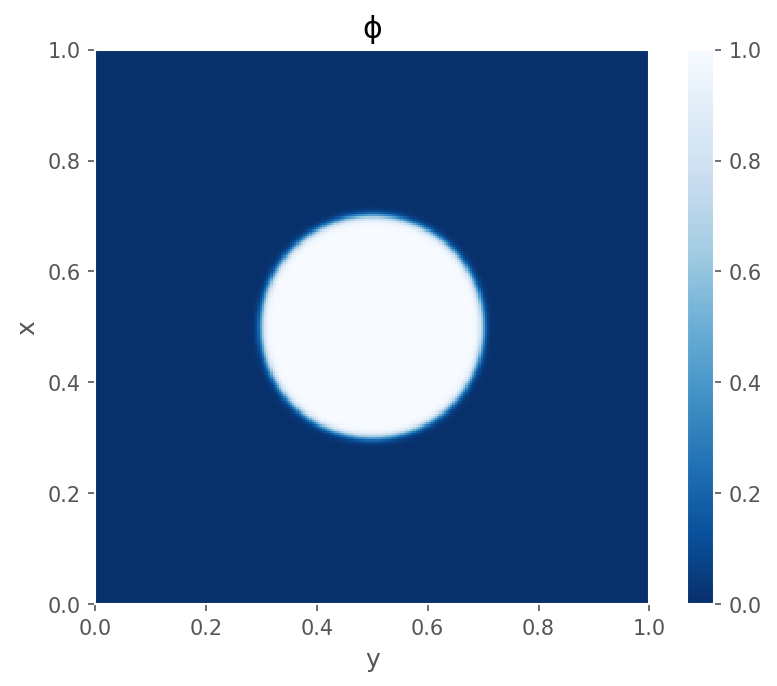

In [8]:
fig, ax = subplots()
pc = ax.pcolormesh(xcr,ycr,transpose(ϕ[1:end-1,:,1]), cmap="Blues_r")
ax.set(
    aspect="equal",
    title="ϕ",
    xlabel="y",
    ylabel="x"
)

fig.colorbar(pc);

Having checked that $\phi$ is as we expect, we can now write $\phi$ to a `continua` file.

In [9]:
fname = "outputdir/continua_phi.h5"
f = h5open(fname, "w")
f["var"] = ϕ
close(f)

As described in the documentation, the temperature field is somewhat more complicated to construct.
The analytic solution for the temperature field is
$$
T(r,t) = \frac{F(s)}{F(\Lambda)} \quad \textrm{where} \quad s = r\sqrt{\frac{Pe}{t}}, \quad F(s) = \int_s^\infty \frac{e^{-z^2 / 4}}{z} dz , \quad \textrm{and} \quad \mathcal{S}\frac{\Lambda^2}{2}e^{\Lambda^2 / 4} F(\Lambda) = 1.
$$
To begin constructing a snapshot of this solution, we first compute $\Lambda$ for the Stefan number $\mathcal{S}$ given in `bou.in`.
We achieve this by rewriting the final equation in the line above as
$$
g(\Lambda) = 0, \quad \textrm{where} \quad g(x) = F(\Lambda) - \frac{2}{Sx^2}e^{-x^2 / 4} ,
$$
and using an iterative Newton solver to find the root.
Gauss-Kronrod quadrature is used to numerically compute the semi-infinite integral via the Julia package `QuadGK.jl`.

In [10]:
Stefan = bou[42,3];

function F(x, rtol)
    f = quadgk(z -> exp(-z^2 / 4)/z, x, Inf, rtol=rtol)[1]
    return f
end

function iterate_for_lambda(x, S, rtol)
    while true
        g = F(x, rtol) - 2/S/x^2*exp(-x^2 / 4)
        g′= exp(-x^2 / 4)*(4/S/x^3 + (1-S)/S/x)
        println("g($x) = $g")
        Δx = -g/g′
        x +=Δx
        abs(Δx) ≤ abs(x)*rtol && break
    end
    return x
end

rtol = 1e-7   # Set tolerance for integral calculation
Λ = iterate_for_lambda(0.5,Stefan,1e-7)

g(0.5) = -1.8776668505849483
g(0.6723074101846056) = -0.7242865859942113
g(0.8577583149921486) = -0.2587639559545374
g(1.0271790757109809) = -0.08102896202949394
g(1.1454108150539257) = -0.01901358265683123
g(1.1942083710610933) = -0.0021132921481377687
g(1.201115233097081) = -3.638203148453867e-5
g(1.201238358880166) = -1.1333235461208346e-8


1.201238397258543

In [11]:
R0 = Λ*sqrt(0.1)

0.37986493481871597

Now we read in the Peclet number from the `bou.in` input, calculate the initial time for the similarity solution, and construct the temperature field

In [12]:
RaT, PrT = bou[27,1:2]   # Rayleigh and Prandtl numbers
Pe = sqrt(RaT*PrT)       # Peclet number

t0 = Pe*(0.2/Λ)^2        # Time value needed for similarity solution

# Create temperature field
T = zeros(nx,ny-1,nz-1);
for i=1:nz-1
    for j=1:ny-1
        for k=1:nx-1
            r = sqrt((xm[k] - 0.5)^2 + (ym[j] - ylen/2)^2)
            if r < 0.2
                T[k,j,i] = 1.0
            else
                T[k,j,i] = F(r*sqrt(Pe/t0), rtol)/F(Λ, rtol)
            end
        end
    end
end

Again, as a sanity check we can plot the newly constructed temperature field.

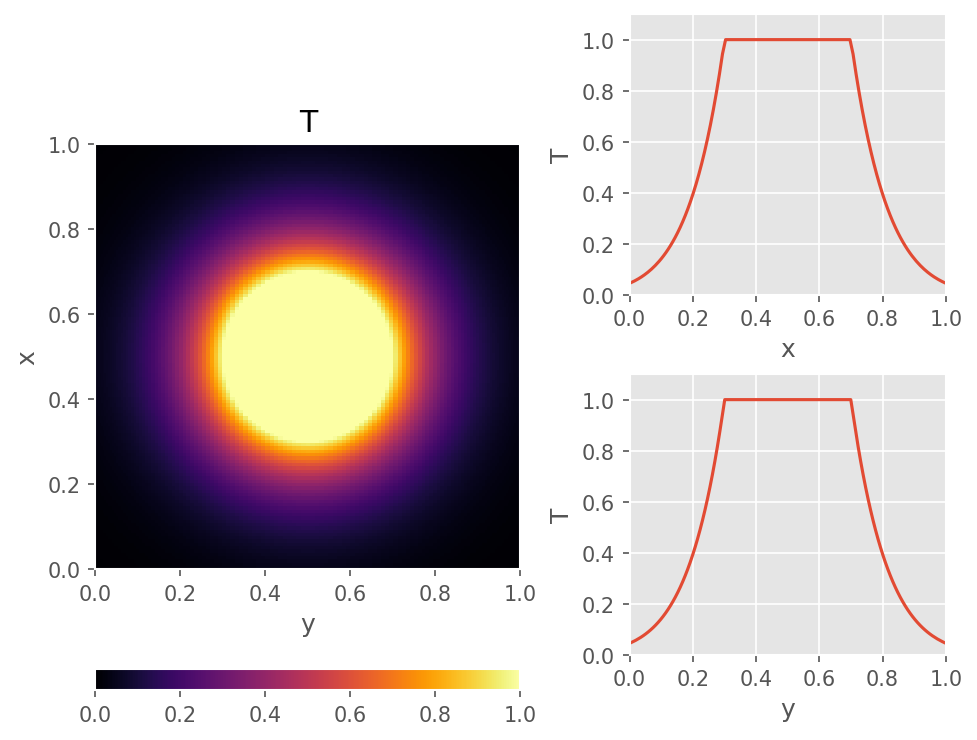

In [13]:
fig = figure(constrained_layout=true)
gs = fig.add_gridspec(1,2)
axim = fig.add_subplot(gs[1])
pc = axim.pcolormesh(xc,yc,transpose(T[1:end-1,:,1]), cmap="inferno", vmin=0, vmax=1)
axim.set(
    aspect="equal",
    title="T",
    xlabel="y",
    ylabel="x"
)

gs1 = gs[2].subgridspec(2,1)
axX = fig.add_subplot(gs1[1])
axX.plot(xm, T[1:end-1,end÷2,1])
axX.set(
    xlim=[0,1],
    xlabel="x",
    ylim=[0,1.1],
    ylabel="T"
)

axY = fig.add_subplot(gs1[2])
axY.plot(ym, T[end÷2,:,1])
axY.set(
    xlim=[0,1],
    xlabel="y",
    ylim=[0,1.1],
    ylabel="T"
)

fig.colorbar(pc, ax=[axim], orientation="horizontal");

Since everything looks good, we can finally write the temperature field to a `continua` file.
We are now ready to run the simulation!

In [14]:
fname = "outputdir/continua_temp.h5"
f = h5open(fname, "w")
f["var"] = T
close(f)